In [254]:
import numpy as np
import pandas as pd
import sklearn

import os
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Load the data

In [255]:
dir_ = os.path.join("data", "arXivMeta_sample")

file_list = []
for file in os.listdir(dir_):
    file_path = os.path.join(dir_, file)
    file_list.append(file_path)
    print(f"using {file}")
    
all_data = pd.concat([pd.read_csv(file, delimiter='\t', na_values='nan') for file in file_list])

using arXivMeta_all_from_2010-01-01_to_2010-07-01.csv
using arXivMeta_all_from_2010-07-02_to_2010-12-31.csv


## Handle NaNs

In [256]:
# count the NaNs
all_data.isnull().sum()

id            6
authors       0
title         6
abstract      6
categories    6
dtype: int64

In [257]:
# show the NaNs
rows_with_nulls = all_data.isnull().any(axis=1)
print("No. of rows with NaNs: ", sum(rows_with_nulls))
all_data[rows_with_nulls][:3]

No. of rows with NaNs:  6


,id,authors,title,abstract,categories
22299,NaN,[],NaN,NaN,NaN
22300,NaN,[],NaN,NaN,NaN
23584,NaN,[],NaN,NaN,NaN


In [258]:
# All the NaNs are aligned in empty rows.
# We can just drop them.
all_data = all_data.dropna(axis=0, how='any', inplace=False)

## Remove suspiciously short abstracts
There are articles where the abstarct serves as a comment rather than a summary, e.g. "Discussion on SOME_REFERENCE."

In [259]:
example = all_data[all_data.id == '1001.2975'].abstract.values[0].strip()
print(example)
len(example)

Comment on "Harold Jeffreys's Theory of Probability Revisited"
[arXiv:0804.3173]


80

Let's just decide that abstracts shorter than 120 characters are not informative (or worse) and remove them.

In [262]:
all_data = all_data.loc[all_data.abstract.str.len() > 120]

## Check for repeated entries

In [206]:
# count repeated entries

print("No. repeated entries:")
for column in all_data:
    print( f"{column:>11}", len(all_data) - len(all_data[column].unique()) )

No. repeated entries:
         id 0
    authors 8805
      title 62
   abstract 90
 categories 51466


In [207]:
# examine the duplicated abstracts
duplicated_abstracts = all_data[nonan_all_data.duplicated(subset='abstract')]
print(len(duplicated_abstracts))
duplicated_abstracts[:3]

90


,id,authors,title,abstract,categories
234,0709.0595,['Shao-Hsuan Chiu'],Observables in multi-detector analyses of supe...,"This paper has been withdrawn by the author,...",hep-ph
747,0805.0198,['Alexander N. Jourjine'],"Minimal gauging of Dirac, Kahler, and Dirac-Ka...",This paper has been withdrawn by the author.\n,math-ph math.MP
2059,0902.2788,"['Ali Pourmohammad', 'Seyed Mohammad Ahadi']",Using SLP Neural Network to Persian Handwritte...,This paper has been withdrawn by the author ...,cs.CV


In [208]:
# among the duplicated abstracts many are just "This paper has been withdrawn ..."
withdrawn = duplicated_abstracts[duplicated_abstracts.abstract.str.contains("^\s+This paper has been withdrawn")]
print(len(withdrawn))

31


In [209]:
# remove those "withdrawn" from all_data and from duplicated
all_data = all_data[~all_data.id.isin(withdrawn.id.values)]
duplicated_abstracts = duplicated_abstracts[~duplicated_abstracts.id.isin(withdrawn.id.values)]
print(len(duplicated_abstracts))
duplicated_abstracts[:10]

59


,id,authors,title,abstract,categories
6136,1001.1922,"['Frédéric Planchet', 'Laurent Faucillon', 'Ma...",Etude du risque syst\'ematique de mortalit\'e,The aim of this paper is to propose a realis...,q-fin.GN q-fin.RM
6192,1001.2058,"['S A Sisson', 'Y Fan']",Likelihood-free Markov chain Monte Carlo,"To appear to MCMC handbook, S. P. Brooks, A....",stat.ME
6538,1001.2975,['Stephen Senn'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
6544,1001.2985,['Arnold Zellner'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
6576,1001.3073,['Dennis Lindley'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
7297,1001.5100,"['Xiwang Cao', 'Lei Hu']","On Exponential Sums, Nowton identities and Dic...","Let $\mathbb{F}_{q}$ be a finite field, $\ma...",cs.IT math.IT
8475,1002.3222,"['Jeroen Keiren', 'Michel A. Reniers', 'Tim A....",Structural Analysis of Boolean Equation Systems,We analyse the problem of solving Boolean eq...,cs.LO
8873,1002.4496,"['Robert Serfling', 'Yijun Zuo']","Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
8879,1002.4509,"['Linglong Kong', 'Ivan Mizera']","Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
10719,1003.5865,"['Dakshina Ranjan Kisku', 'Phalguni Gupta', 'J...",Offline Signature Identification by Fusion of ...,This paper uses Support Vector Machines (SVM...,cs.CV cs.LG


In [212]:
duplicated_abstracts[duplicated_abstracts.duplicated(subset='title')]

,id,authors,title,abstract,categories
6544,1001.2985,['Arnold Zellner'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
6576,1001.3073,['Dennis Lindley'],"Comment on ""Harold Jeffreys's Theory of Probab...","Comment on ""Harold Jeffreys's Theory of Prob...",stat.ME
8879,1002.4509,"['Linglong Kong', 'Ivan Mizera']","Discussion of ""Multivariate quantiles and mult...","Discussion of ""Multivariate quantiles and mu...",math.ST stat.TH
16952,1010.0836,"['Arthur Gretton', 'Kenji Fukumizu', 'Bharath ...",Discussion of: Brownian distance covariance,"Discussion on ""Brownian distance covariance""...",stat.AP
16954,1010.0839,['Christopher R. Genovese'],Discussion of: Brownian distance covariance,"Discussion on ""Brownian distance covariance""...",stat.AP


In [133]:
duplicated_abstracts[:].groupby('abstract')['title'].apply(list)[:1]

abstract
  After two decades of repository development, some conclusions may be drawn as\nto which type of repository and what kind of service best supports digital\nscholarly communication, and thus the production of new knowledge. Four types\nof publication repository may be distinguished, namely the subject-based\nrepository, research repository, national repository system and institutional\nrepository. Two important shifts in the role of repositories may be noted. With\nregard to content, a well-defined and high quality corpus is essential. This\nimplies that repository services are likely to be most successful when\nconstructed with the user and reader uppermost in mind. With regard to service,\nhigh value to specific scholarly communities is essential. This implies that\nrepositories are likely to be most useful to scholars when they offer dedicated\nservices supporting the production of new knowledge. Along these lines,\nchallenges and barriers to repository development may be i

In [124]:
nonan_all_data[nonan_all_data.duplicated(subset='title')].groupby('title').apply(list)

title
A New Email Retrieval Ranking Approach                                                                                                                                                                             [id, authors, title, abstract, categories]
A Parsing Scheme for Finding the Design Pattern and Reducing the\n  Development Cost of Reusable Object Oriented Software                                                                                          [id, authors, title, abstract, categories]
A fast and robust patient specific Finite Element mesh registration\n  technique: application to 60 clinical cases                                                                                                 [id, authors, title, abstract, categories]
A note on precised Hardy inequalities on Carnot groups and Riemannian\n  manifolds                                                                                                                                 [id, authors, title, 

In [129]:
df = pd.DataFrame( {'a':['A','A','B','B','B','C'], 'b':[1,2,5,5,4,6]})
df

,a,b
0,A,1
1,A,2
2,B,5
3,B,5
4,B,4
5,C,6


In [135]:
df.groupby('a')['b'].apply(list)

a
A       [1, 2]
B    [5, 5, 4]
C          [6]
Name: b, dtype: object

In [79]:
# franction of records with more than one category
sum( len(str(category).split())>1 for category in all_data.categories ) / len(all_data)

0.4091766514130017

In [74]:
sum(mygen)

23427

In [59]:
np.isnan('nan')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

---

### old

In [7]:
# load the csv's obtained with 'arXiv_metadata_harvester.ipynb'

#dir_ = os.path.join("data", "arXivMeta_completed")
#dir_ = os.path.join("data", "arXivMeta_example_bak")

dfs = {}

# create dict of file-lists dfs = {'cs': [file1, ...], 'math': ..., etc.}
for file in os.listdir(dir_):
    info = re.search(r'arXivMeta_(.+?)_(.+?)\.(\w+?)', file)
    cat = info.group(1)
    date = info.group(2)
    print(f'{cat:>9}: {date}')
    
    file_path = os.path.join(dir_, file)
    
    if cat not in dfs:
        dfs[cat] = [file_path]
    else:
        dfs[cat].append(file_path)

# create dict of data_frames dfs = {'cs': pd.DataFrame(), 'math': ..., etc.}       
def getdf(file_list):
    cat_dfs = [pd.read_csv(file, delimiter='\t') for file in file_list]
    return pd.concat(cat_dfs)

dfs = {cat: getdf(cat_files) for (cat, cat_files) in dfs.items()}

       cs: from_2016-01-01_to_2016-12-31
     math: from_2016-01-01_to_2016-07-01
     math: from_2016-07-02_to_2016-12-31
  physics: from_2016-01-01_to_2016-05-01
  physics: from_2016-05-02_to_2016-09-01
  physics: from_2016-09-02_to_2016-12-31
    q-bio: from_2016-01-01_to_2016-12-31
    q-fin: from_2016-01-01_to_2016-12-31
     stat: from_2016-01-01_to_2016-12-31


---

# Explore and select the data

In [8]:
# now we have for example

dfs['math'][:3]

,id,prim_cat,sec_cats,title,abstract
0,0704.0189,math,math.GR,Monoid generalizations of the Richard Thompson...,"The groups G_{k,1} of Richard Thompson and G..."
1,0704.1313,math,math.GT math.CO,Mutant knots and intersection graphs,We prove that if a finite order knot invaria...
2,0704.2146,math,math.CO,Connected Edge-Disjoint Unions of Tur\'an Graphs,A finite connected graph $G_r^\sigma$ is con...


In [9]:
# check if there are no duplicates (at least by 'id')

[(cat, 0 == len(df.id) - len(df.id.unique())) for (cat,df) in dfs.items()]

[('cs', True),
 ('math', True),
 ('physics', True),
 ('q-bio', True),
 ('q-fin', True),
 ('stat', True)]

In [10]:
# concat all data_frames into one

full_df = pd.concat(dfs.values())

# get a 10% sample to play with

sample_df = full_df.sample(frac=0.1, random_state=123)
sample_df.reset_index(inplace=True)
len(sample_df)

16128

In [11]:
def show_cats(df):
    
    cats = df.prim_cat.unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df.prim_cat == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
physics,8.003
math,4.546
cs,2.62
stat,0.565
q-bio,0.295
q-fin,0.099


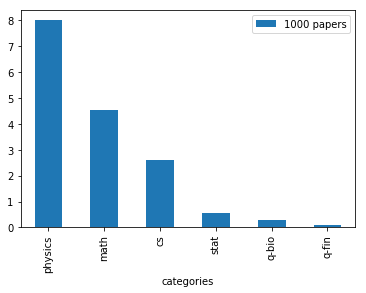

In [12]:
# plot the number of papers in each class
# the dataset is highly unbalanced, there's orders of magnitude between the most and the least frequent class

show_cats(sample_df)

# the world of quantative finance seems to be less keen on spending time writing papers than physicists

In [13]:
# get primary_categories (prim_cat) and text (title+abstract) only
# and safe those in 'bare data_frames'

def strip(df):
    df_2 = pd.concat([(df.title + " " + df.abstract).astype('str'),
                      df.prim_cat.astype('category')], axis=1)
    df_2.columns = ['text', 'label']
    return df_2

bare_dfs = {cat: strip(df) for (cat, df) in dfs.items()}

bare_sample_df = strip(sample_df)

In [14]:
# now we have for example

with pd.option_context('display.max_colwidth', 110):
    display(bare_sample_df[:3])

,text,label
0,The IBM 2016 Speaker Recognition System In this paper we describe the recent advancements made in the IB...,cs
1,The 2(2S+1)- Formalism and Its Connection with Other Descriptions In the framework of the Joos-Weinberg ...,math
2,Regression-based Intra-prediction for Image and Video Coding By utilizing previously known areas in an i...,cs


---

### One could also have a look at the papers' secondary categories of which there are almost 200 and there can be many such categories per paper. Maybe later...

In [15]:
# TODO side-project:
# classify by subcategories (first entries in the list in 'sec_cats' of each paper)

In [16]:
# one-hot-encode the 
ids_with_cats_ugly = full_df[['id', 'sec_cats']].set_index('id').sec_cats.str.split(expand=True).stack()
print(ids_with_cats_ugly[:10])

id_with_cats_df = pd.get_dummies(ids_with_cats_ugly).groupby(level=0).sum()
id_with_cats_df[:3]

id          
0704.0361  0      cs.IT
           1    math.IT
0704.0590  0      cs.IT
           1    math.IT
0704.0671  0      cs.IT
           1      cs.LG
           2    math.IT
0704.0805  0      cs.IT
           1    math.IT
0704.0858  0      cs.CR
dtype: object


,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
id,,,,,,,,,,,,,,,,,,,,,
0704.0189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(id_with_cats_df.columns)

168

In [18]:
# TODO take care of adap-org (nlin.AO), chao-dyn(nlin.CD), patt-sol (nlin.PS) etc.:

# Each category should be in the format 'general.specic' (e.g. 'astr-ph.CO') or just 'general' (e.g. 'astro-ph')
# but some of our columns are assigned to 'specific' in the spelled-out format (eg. chao-dyn instead of nlin.CD)
# See https://arxiv.org/ and http://arxitics.com/help/categories

# for column in id_with_cats_df:
#     print(column)

---

### Abstracts of scientific papers tend to be written in a formal style, not contain typos, no direct citations, little references, ...

In [19]:
# take a look at a few abstracts

import random
  
for _ in range(3):
    print(bare_sample_df.text.iloc[random.choice(range(len(bare_sample_df)))])
    print("---")

Chemical Abundance Analysis of Moving Group W11450 (Latham 1)   We present elemental abundances for all seven stars in Moving Group W11450
(Latham 1) to determine if they may be chemically related. These stars appear
to be both spatially and kinematically related, but no spectroscopic abundance
analysis exists in literature. Abundances for eight elements were derived via
equivalent width analyses of high resolution (R $\sim$60,000), high
signal-to-noise ratio ($\langle$SNR$\rangle\sim$100) spectra obtained with the
Otto Struve 2.1m telescope and Sandiford Echelle Spectrograph at McDonald
Observatory. The large star-to-star scatter in metallicity, -0.55 $\leq$ [Fe/H]
$\leq$ 0.06 dex ($\sigma$= 0.25), implies these stars were not produced from
the same chemically homogeneous molecular cloud, and are therefore not part of
a remnant or open cluster as previously proposed. Prior to this analysis, it
was suggested that two stars in the group, W11449 & W11450, are possible wide
binaries. The 

### One messy but informative kind of writing they have are LateX formulas.

In [20]:
bare_sample_df.text[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the $Q\\mathcal{V}$ operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n$Q$-invariant off-shell configurations in four-dimensional $\\mathcal{N}=2$\r\nsupergravity with $AdS_{2} \\times S^{2}$ boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin $\\mathcal{N}=2$ supergravity. We explain cancellations co

### Let's map those into a single 'word'

In [21]:
# mask all LaTeX with a single word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace '\$(.+)?\$' with ' _LATEX_ '
    """

    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\$(.+)?\$', ' _LATEX_ ')

In [22]:
delatex = DeLaTeX()
delatex.transform(bare_sample_df.text)[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the  _LATEX_  operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n _LATEX_ \r\nsupergravity with  _LATEX_  boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin  _LATEX_  supergravity. We explain cancellations concerning\r\n _LATEX_  supergravity that were observed in\r\narXiv:1111.1161. We also make com

---

## Let's build a simple untuned pipeline with a couple shallow classifiers
### We relay on the *class_weight* argument to account for the imbalance of our data

In [23]:
# Choose the data_frame

work_df = bare_sample_df

print(len(work_df))
work_df.dtypes

16128


text       object
label    category
dtype: object

In [24]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(work_df.text, work_df.label, test_size=0.33, random_state=123)

In [25]:
# encode the labels, 'cs' -> 0, ..., 'stat' -> 5

from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()
y_train = label_e.fit_transform(label_train)
y_test = label_e.transform(label_test)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'physics', 'q-bio', 'q-fin', 'stat']


### Let's first build the pipe and push the data trough step by step.

In [26]:
notex_text_train = delatex.fit_transform(text_train)
notex_text_test = delatex.transform(text_test)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(notex_text_train)
word_counts_test = count_v.transform(notex_text_test)
word_counts_train.shape

(10805, 37937)

In [31]:
# Why is there fewer rows? Were they empty?

In [32]:
# take a look at the most frequent words (after using the 'max_df' above)

sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(sum_word_counts_train[0, i], word) for word, i in count_v.vocabulary_.items()],reverse=True)[:15]

# The '_latex_' word of ours id dangerously high.
# Yet I would still hope that it is underrepresented in quantitative biology or quantitative finance
# We'll settle on max_df=0.8
# 
# Maybe we should have balanced the classes...

[(113420, 'the'),
 (71769, 'of'),
 (39808, 'and'),
 (35847, 'in'),
 (30939, 'to'),
 (23502, 'we'),
 (21230, 'is'),
 (20436, 'for'),
 (15495, 'that'),
 (14938, '_latex_'),
 (14689, 'with'),
 (12535, 'on'),
 (11021, 'this'),
 (10733, 'are'),
 (10459, 'by')]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

def build_arXivMeta_clf(model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX() ))
    pipe.append(( 'count_v', CountVectorizer(strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
    pipe.append(( 'tfidf_t', TfidfTransformer(use_idf=False)  ))
    pipe.append(( 'sgd_clf', model  ))

    return Pipeline(pipe)

In [37]:
# our first model, an linear SVMM with stochastic gradient descent

from sklearn.linear_model import SGDClassifier

arXivMeta_clf_1 = build_arXivMeta_clf(
    SGDClassifier(loss='hinge', class_weight="balanced", n_jobs=-1, max_iter=1000, tol=1e-3)
)
arXivMeta_clf_1.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Ok, let's just have some fun first:

In [38]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms  This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
We offer a novel less intuitive proof of $\limit_{x\to 0} x = 0$,
""",
"""
infllation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])


label_e.inverse_transform(arXivMeta_clf_1.predict(random_abstracts))

array(['cs', 'physics', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

In [39]:
# looks promising

### Check the multilabel classification accuracy

In [40]:
from sklearn import metrics

def show_metrics(clf):
    predicted_y_test = clf.predict(text_test)
    print(metrics.classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
    print(metrics.confusion_matrix(y_test, predicted_y_test))

In [41]:
show_metrics(arXivMeta_clf_1)

              precision    recall  f1-score   support

          cs       0.69      0.71      0.70       894
        math       0.80      0.74      0.77      1510
     physics       0.93      0.90      0.91      2633
       q-bio       0.42      0.55      0.48        80
       q-fin       0.31      0.57      0.40        30
        stat       0.33      0.59      0.42       176

   micro avg       0.80      0.80      0.80      5323
   macro avg       0.58      0.67      0.61      5323
weighted avg       0.82      0.80      0.81      5323

[[ 633  107   37   12    8   97]
 [ 179 1115  121   10   16   69]
 [  66  143 2362   29    7   26]
 [  10    4   11   44    1   10]
 [   1    6    1    0   17    5]
 [  30   26    3    9    5  103]]


In [42]:
# TODO: understand what the above values are

In [43]:
# try a random forest

from sklearn.ensemble import RandomForestClassifier

arXivMeta_clf_2 = build_arXivMeta_clf(
    RandomForestClassifier(class_weight = 'balanced', n_estimators=100, max_depth=10, criterion='entropy', random_state=123)
)
arXivMeta_clf_2.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto...tors=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False))])

In [44]:
show_metrics(arXivMeta_clf_2)

              precision    recall  f1-score   support

          cs       0.61      0.59      0.60       894
        math       0.67      0.74      0.70      1510
     physics       0.89      0.81      0.85      2633
       q-bio       0.31      0.41      0.35        80
       q-fin       0.62      0.43      0.51        30
        stat       0.33      0.48      0.40       176

   micro avg       0.74      0.74      0.74      5323
   macro avg       0.57      0.58      0.57      5323
weighted avg       0.75      0.74      0.74      5323

[[ 530  198   64   15    3   84]
 [ 176 1119  156    7    5   47]
 [  96  318 2145   45    0   29]
 [  15    3   22   33    0    7]
 [   4    9    2    0   13    2]
 [  46   30    8    7    0   85]]


In [ ]:
# TODO:

# add LogisticRegression, RidgeClassifier with the 'class_weight=balanced' argument

# make a prettier confusion matrix with a heat_map 

# grid search with cross validation

# try Hash Vectorizer instead of CountVectorizer
# balance the classes by up-/down-sampling and use other models (MultiNomial Naive Bayes)
# out-of-core learning ?

# see how accuracy scales with data volume (we have 800 MB to go around)

# unsupervised learning:
# LDA
# clustering
# visualization: t-SNE ?

# deep learning ?

# multilabel learning (with the secondary classes) ?